# **EDA `reviews_gm`**

In [11]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore 
from scipy.stats import ttest_ind # type: ignore
from sklearn.feature_extraction.text import CountVectorizer # type: ignore
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # type: ignore
from textblob import TextBlob # type: ignore
import swifter # type: ignore
import dask.dataframe as dd # type: ignore
from wordcloud import WordCloud # type: ignore
import glob # type: ignore


In [12]:
reviews_gm = pd.read_parquet('reviews_gm.parquet')

In [13]:
reviews_gm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2691539 entries, 0 to 2849999
Data columns (total 10 columns):
 #   Column   Dtype         
---  ------   -----         
 0   user_id  float64       
 1   name     object        
 2   time     int64         
 3   rating   int64         
 4   text     object        
 5   pics     object        
 6   resp     object        
 7   gmap_id  object        
 8   date     datetime64[ns]
 9   year     int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(5)
memory usage: 215.6+ MB


Filtro por los negocios de comida (obtenidos de metadatos)

In [14]:
metadatos = pd.read_csv(r'metadatos_filtered.csv')

In [15]:
# Filtrar reviews_gm manteniendo solo los gmap_id que están en metadatos
filtered_reviews = reviews_gm[reviews_gm["gmap_id"].isin(metadatos["gmap_id"])]

# Verificar cuántos registros quedaron después del filtrado
print(f"Cantidad de reviews después del filtrado: {len(filtered_reviews)}")
print(filtered_reviews.head())

Cantidad de reviews después del filtrado: 998663
          user_id              name        time  rating  \
514  1.130683e+20     Edwin Ashurst  1537195868       5   
515  1.059416e+20   Douglas Gummere  1537402367       1   
516  1.098577e+20      David Powell  1534936396       5   
517  1.147377e+20  Hillary Hutchins  1555464332       5   
518  1.089870e+20        Ajay patel  1558392170       5   

                                                  text  pics  resp  \
514  The salads were lackluster though with well wr...  None  None   
515  Love this place. Great little restaurant, with...  None  None   
516  A classy restaurant to match the charm of the ...  None  None   
517                     Great atmosphere and good food  None  None   
518                                          Good food  None  None   

                                   gmap_id                date  year  
514  0x8894b5a7a7909725:0xe4687299fd288188 2018-09-17 14:51:08  2018  
515  0x8894b5a7a7909725:0xe468729

In [16]:
reviews = filtered_reviews.copy()

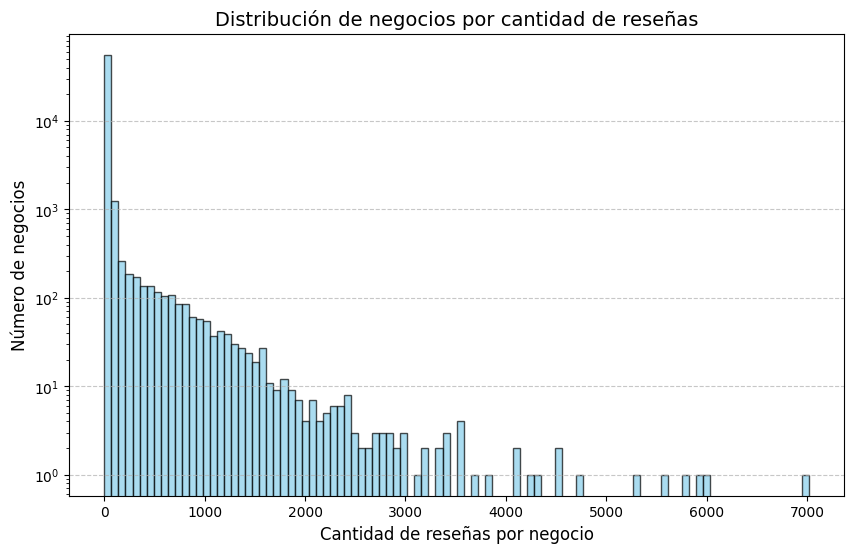

In [17]:
# Contar cuántas reseñas tiene cada negocio (gmap_id)
business_review_counts = reviews_gm['gmap_id'].value_counts()

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(business_review_counts, bins=100, color='skyblue', edgecolor='black', alpha=0.7)

# Personalizar el gráfico
plt.title("Distribución de negocios por cantidad de reseñas", fontsize=14)
plt.xlabel("Cantidad de reseñas por negocio", fontsize=12)
plt.ylabel("Número de negocios", fontsize=12)
plt.yscale("log")  # Escala logarítmica para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


In [18]:
reviews['gmap_id'].nunique()

5423

In [7]:
reviews.describe()

,user_id,time,rating,date,year
count,9.986630e+05,9.986630e+05,998663.000000,998663,998663.000000
mean,1.092390e+20,1.559326e+09,4.241168,2019-05-31 18:00:40.086340096,2018.941660
min,1.000000e+20,1.484785e+09,1.000000,2017-01-19 00:10:24,2017.000000
25%,1.046465e+20,1.532516e+09,4.000000,2018-07-25 10:55:06,2018.000000
50%,1.092317e+20,1.558018e+09,5.000000,2019-05-16 14:41:17,2019.000000
75%,1.138433e+20,1.582657e+09,5.000000,2020-02-25 18:52:50,2020.000000
max,1.184467e+20,1.631069e+09,5.000000,2021-09-08 02:50:02,2021.000000
std,5.317804e+18,3.531639e+07,1.150007,NaN,1.161173


In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998663 entries, 514 to 2847063
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  998663 non-null  float64       
 1   name     998663 non-null  object        
 2   time     998663 non-null  int64         
 3   rating   998663 non-null  int64         
 4   text     609543 non-null  object        
 5   pics     42548 non-null   object        
 6   resp     134381 non-null  object        
 7   gmap_id  998663 non-null  object        
 8   date     998663 non-null  datetime64[ns]
 9   year     998663 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(5)
memory usage: 80.0+ MB


In [9]:
# Eliminar las columnas 'pics' y 'resp' porque tienen muchos nulos
reviews = reviews.drop(columns=["pics", "resp"])

# Eliminar las columnas 'name' porque no es util para los análisis
reviews = reviews.drop(columns=["name"])


In [10]:
# Verificar la cantidad de valores nulos en cada columna
missing_values = reviews.isnull().sum()

# Filtrar solo las columnas que tienen valores nulos
missing_values = missing_values[missing_values > 0]

# Mostrar el resultado
if missing_values.empty:
    print("No hay valores nulos en el DataFrame.")
else:
    print("Valores nulos por columna:")
    print(missing_values)

Valores nulos por columna:
text    389120
dtype: int64


Promedio de estrellas: 4.24

Distribución de calificaciones:
rating
1     58330
2     40164
3     98520
4    206965
5    594684
Name: count, dtype: int64


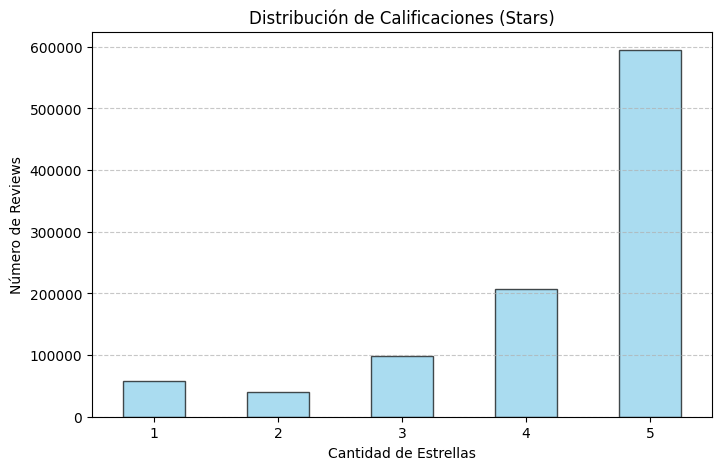

In [13]:
# Calcular el promedio de calificaciones (rating)
mean_rating = reviews['rating'].mean()

# Contar la cantidad de cada calificación
rating_distribution = reviews['rating'].value_counts().sort_index()

# Mostrar resultados
print(f"Promedio de estrellas: {mean_rating:.2f}")
print("\nDistribución de calificaciones:")
print(rating_distribution)

# Graficar la distribución para visualizar posibles sesgos
plt.figure(figsize=(8,5))
rating_distribution.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)

# Personalización del gráfico
plt.xlabel('Cantidad de Estrellas')
plt.ylabel('Número de Reviews')
plt.title('Distribución de Calificaciones (Stars)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

### Conclusiones sobre la Distribución de Calificaciones

- Existe una **clara tendencia hacia calificaciones altas**, con una gran mayoría de reviews otorgando **5 estrellas**.
- La cantidad de calificaciones **aumenta progresivamente** desde 1 hasta 5 estrellas, mostrando que los usuarios tienden a dejar opiniones más positivas que negativas.
- Las calificaciones de **1 y 2 estrellas son significativamente menores**, lo que indica que los clientes insatisfechos dejan menos reseñas o que los negocios mal calificados tienden a cerrar.
- El sesgo hacia calificaciones altas podría deberse a **factores psicológicos** (usuarios más propensos a dejar reviews cuando tienen experiencias muy positivas) o a **mecanismos de reputación de la plataforma**.
- Este patrón justifica la necesidad del **Bayesian Average Score**, ya que ayuda a mitigar la influencia de calificaciones extremas y proporciona un ranking más equilibrado.

#### Conclusión General
El gráfico muestra una **distribución asimétrica**, donde la mayoría de los negocios reciben calificaciones **positivas**. Esto debe considerarse al analizar la reputación de un negocio, ya que la media simple de estrellas puede no ser la mejor métrica para evaluar su calidad real.


- **Tendencia temporal**: Analizar si el promedio de calificaciones cambia con el tiempo (`date`).

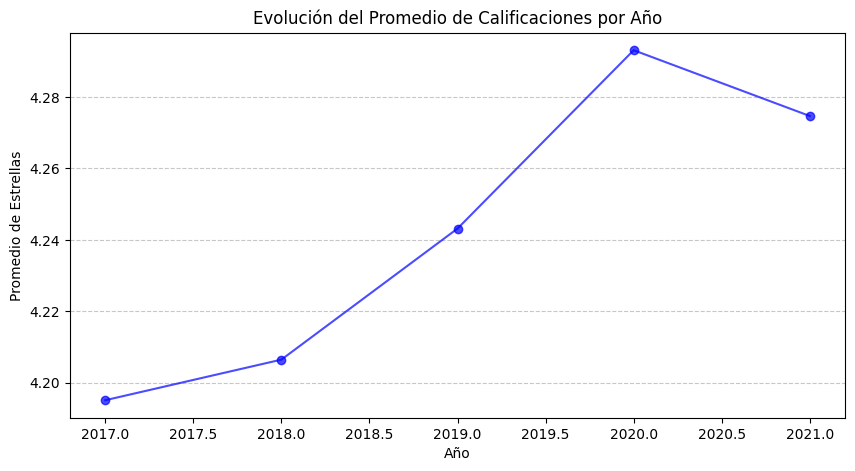

In [15]:
# Convertir la columna 'date' a formato datetime (si no lo está)
reviews['date'] = pd.to_datetime(reviews['date'])

# Agrupar por año y calcular el promedio de estrellas
reviews['year'] = reviews['date'].dt.year
rating_trend = reviews.groupby('year')['rating'].mean()

# Graficar la tendencia del promedio de estrellas por año
plt.figure(figsize=(10,5))
plt.plot(rating_trend.index, rating_trend.values, marker='o', linestyle='-', color='b', alpha=0.7)

# Personalización del gráfico
plt.xlabel('Año')
plt.ylabel('Promedio de Estrellas')
plt.title('Evolución del Promedio de Calificaciones por Año')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


### Conclusiones sobre la Evolución del Promedio de Calificaciones por Año

- Se observa una **tendencia ascendente** en el promedio de calificaciones desde **2017 hasta 2020**, alcanzando su punto más alto en 2020.
- En **2021, el promedio de estrellas disminuye ligeramente**, lo que podría indicar un cambio en la percepción de los usuarios o factores externos que afectaron las calificaciones.
- El crecimiento sostenido hasta 2020 sugiere una **mejora en la calidad del servicio**, un mayor incentivo para recibir buenas calificaciones o cambios en la cultura de reseñas.
- La caída en 2021 podría deberse a **factores externos**, como cambios en la plataforma, crisis económicas o nuevas expectativas de los clientes.

#### Conclusión General
El gráfico muestra una **tendencia positiva en la percepción de los negocios hasta 2020**, seguida de una leve corrección en 2021. Es importante analizar más detalles para entender las razones detrás de esta evolución.

## Análisis de contenido de las reviews (`text`)
- **Longitud de las reviews**: Analizar la distribución de la cantidad de palabras en `text`.
- **Análisis de palabras clave**: Identificar términos más usados en reviews positivas y negativas.

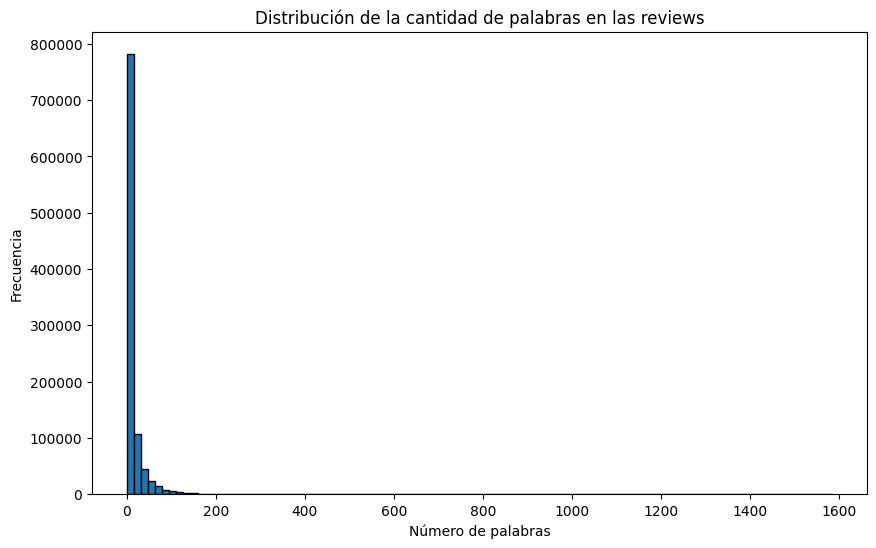

In [17]:
# Calcular la longitud de cada review (número de palabras)
reviews['review_length'] = reviews['text'].apply(lambda x: len(str(x).split()))

# Mostrar distribución de longitud de las reviews
plt.figure(figsize=(10, 6))
plt.hist(reviews['review_length'], bins=100, edgecolor='black')
plt.title('Distribución de la cantidad de palabras en las reviews')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()

### Conclusiones sobre la Distribución de la Cantidad de Palabras en las Reviews

- La mayoría de las reviews contienen **muy pocas palabras**, con un fuerte pico en valores bajos.
- La distribución está **altamente sesgada a la izquierda**, indicando que la mayoría de los usuarios dejan comentarios breves.
- Existen algunas reviews con **gran cantidad de palabras**, pero son casos atípicos y representan una minoría.
- El comportamiento sugiere que los usuarios prefieren **reseñas cortas y directas**, posiblemente debido a la facilidad de escritura rápida o a la influencia de plataformas con reseñas cortas.

#### Conclusión General
El gráfico confirma que la mayoría de las reviews son **breves**, lo que puede influir en el análisis de sentimiento o en modelos de NLP, ya que habrá menos contexto en la mayoría de los casos.


---

## Análisis de Nube de Palabras
Se generan nubes de palabras para analizar las diferencias en el vocabulario utilizado en reviews positivas (4.5 estrellas) y negativas (1 estrella). El objetivo es identificar patrones en la forma en que los usuarios expresan sus experiencias en cada caso.

In [32]:
# Separar reviews positivas y negativas
positive_reviews = reviews[reviews['rating'] >= 4].copy()
negative_reviews = reviews[reviews['rating'] <= 1].copy()

# Reemplazar valores nulos en 'text' por cadenas vacías
positive_reviews['text'] = positive_reviews['text'].fillna("")
negative_reviews['text'] = negative_reviews['text'].fillna("")

# Vectorizar palabras más comunes
vectorizer = CountVectorizer(stop_words='english', max_features=20)

# Extraer palabras más frecuentes en reviews positivas
positive_words = vectorizer.fit_transform(positive_reviews['text'])
positive_freq = pd.DataFrame(
    positive_words.sum(axis=0).tolist()[0],
    index=vectorizer.get_feature_names_out(),
    columns=['frequency']
).sort_values(by='frequency', ascending=False)

# Extraer palabras más frecuentes en reviews negativas
vectorizer = CountVectorizer(stop_words='english', max_features=2000)  # Nuevo vectorizador para evitar conflictos
negative_words = vectorizer.fit_transform(negative_reviews['text'])
negative_freq = pd.DataFrame(
    negative_words.sum(axis=0).tolist()[0],
    index=vectorizer.get_feature_names_out(),
    columns=['frequency']
).sort_values(by='frequency', ascending=False)

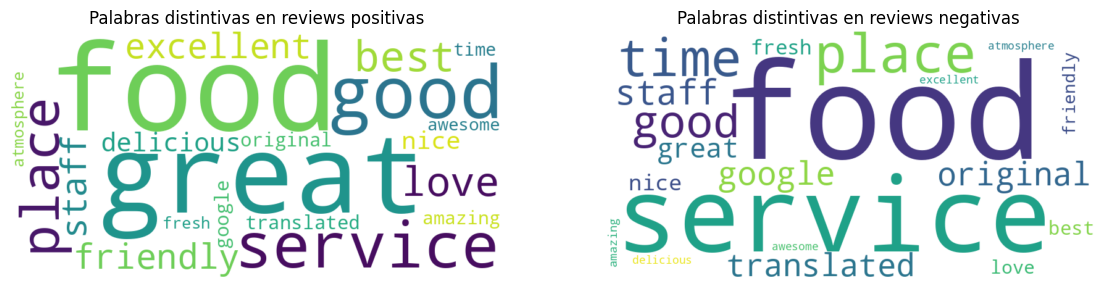

In [33]:
# Definir un umbral de diferencia para considerar una palabra distintiva
threshold = 5000  # Ajusta según necesidad

# Calcular diferencia de frecuencia
word_differences = (positive_freq - negative_freq).abs()

# Filtrar palabras que tienen una diferencia significativa en frecuencia asegurando índices coincidentes
positive_distinct = positive_freq.loc[word_differences['frequency'] > threshold]
negative_distinct = negative_freq.loc[word_differences['frequency'] > threshold]

# Crear nubes de palabras con términos más diferenciadores
wordcloud_positive_distinct = WordCloud(
    width=800, height=400, background_color='white'
).generate_from_frequencies(positive_distinct['frequency'].to_dict())

wordcloud_negative_distinct = WordCloud(
    width=800, height=400, background_color='white'
).generate_from_frequencies(negative_distinct['frequency'].to_dict())

# Mostrar las nuevas nubes de palabras
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive_distinct, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras distintivas en reviews positivas')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative_distinct, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras distintivas en reviews negativas')

plt.show()

### Conclusiones sobre las Palabras Distintivas en Reviews Positivas y Negativas

#### 1. Reviews Positivas
- Las palabras más destacadas en las reviews positivas son **"food"**, **"great"**, **"service"**, **"good"** y **"place"**.
- Términos como **"excellent"**, **"best"**, **"delicious"** y **"love"** reflejan una alta satisfacción con la comida y el servicio.
- La presencia de **"friendly"** y **"awesome"** sugiere que la experiencia general y el trato del personal son factores clave en las calificaciones positivas.

#### 2. Reviews Negativas
- En las reviews negativas, las palabras más repetidas son **"food"**, **"service"**, **"place"** y **"time"**.
- El término **"translated"** aparece con frecuencia, lo que podría indicar problemas con traducciones o expectativas mal gestionadas.
- Aunque hay palabras como **"good"** y **"great"**, su contexto probablemente sea diferente, por ejemplo, comparaciones con experiencias previas o expectativas no cumplidas.

#### 3. Comparación entre Positivas y Negativas
- Tanto en reviews positivas como negativas, los aspectos más mencionados son **"food"** y **"service"**, lo que indica que son los factores clave en la experiencia del usuario.
- En las positivas predominan palabras con carga emocional positiva (**"love"**, **"best"**, **"delicious"**), mientras que en las negativas aparecen términos más neutros y de contexto variable (**"time"**, **"translated"**).
- La experiencia del **personal y la atención** parece ser un factor importante tanto en valoraciones positivas como negativas.

#### Conclusión General
El análisis sugiere que la calidad de la comida y el servicio son los aspectos más determinantes en la satisfacción del cliente. La diferencia entre reseñas positivas y negativas radica en el tono y en ciertas palabras clave que reflejan expectativas cumplidas o insatisfacción.


---

### Análisis de sentimientos
Se generan las columns vader_score y textbold_score que representan los índices de sentimiento, mediante dos modelos diferentes. Hay varias celdas porque es un análisis muy largo y si se pausa, se puede continuar, sin perder el avance

In [ ]:
# Definir el tamaño del chunk
chunk_size = 500000  # Procesar en bloques de 50000 reviews

# Función de análisis de sentimiento
def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vader_score = analyzer.polarity_scores(text)['compound']
    textblob_score = TextBlob(text).sentiment.polarity
    return pd.Series([vader_score, textblob_score])

# Iterar sobre los datos en chunks
for start in range(0, len(reviews), chunk_size):
    end = min(start + chunk_size, len(reviews))
    chunk = reviews.iloc[start:end].copy()  # Copia para evitar modificaciones en el DataFrame original

    # Aplicar análisis de sentimiento con swifter
    chunk[['vader_score', 'textblob_score']] = chunk['text'].swifter.apply(lambda x: analyze_sentiment(str(x))).apply(pd.Series)

    # 🔹 Guardar cada chunk en un archivo Parquet para no perder datos
    chunk.to_parquet(f"sentiment_chunk_gm_{start}.parquet")

    print(f"✅ Procesado y guardado chunk {start}-{end}")

Pandas Apply:   0%|          | 0/500000 [00:00<?, ?it/s]

✅ Procesado y guardado chunk 0-500000


Pandas Apply:   0%|          | 0/498663 [00:00<?, ?it/s]

✅ Procesado y guardado chunk 500000-998663


Carga de los dataset generados en uno solo

In [ ]:
# Buscar todos los archivos guardados
chunk_files = glob.glob("sentiment_chunk_gm_*.parquet")

# Cargar y combinar todos los chunks
reviews_final = pd.concat([pd.read_parquet(f) for f in chunk_files], ignore_index=True)

# Verificar que todo esté unido
print(f"Dataset final: {reviews_final.shape[0]} filas, {reviews_final.shape[1]} columnas")


Dataset final: 998663 filas, 10 columnas


## Análisis de las distribuciones de sentimiento
Se analizan cómo se distribuyen los sentimientos de las reviews según VADER y TextBlob.

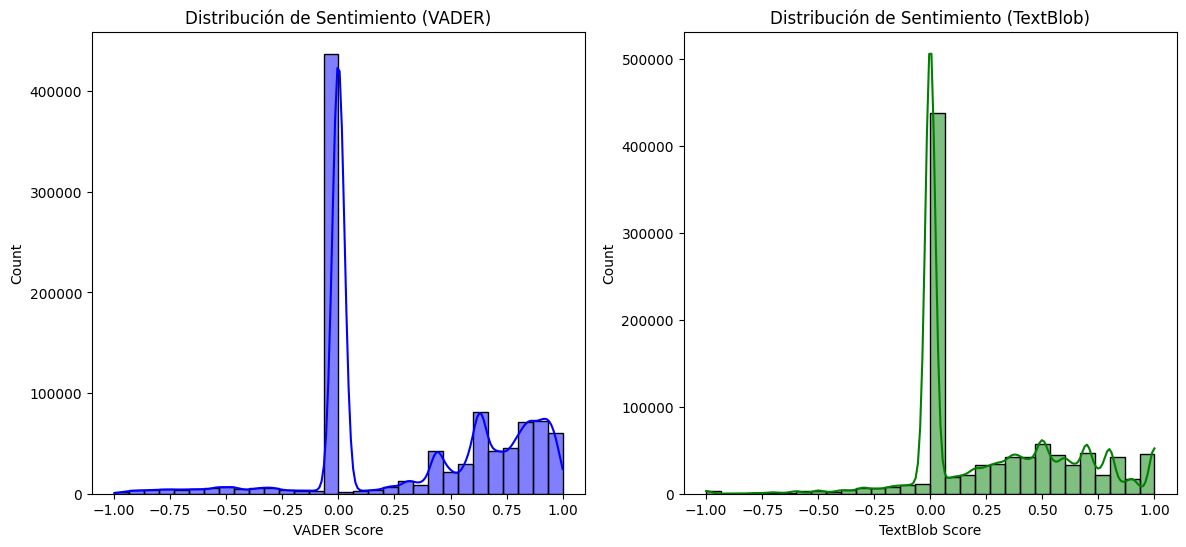

In [3]:
plt.figure(figsize=(14, 6))

# VADER
plt.subplot(1, 2, 1)
sns.histplot(reviews_final['vader_score'], bins=30, kde=True, color='blue')
plt.title("Distribución de Sentimiento (VADER)")
plt.xlabel("VADER Score")

# TextBlob
plt.subplot(1, 2, 2)
sns.histplot(reviews_final['textblob_score'], bins=30, kde=True, color='green')
plt.title("Distribución de Sentimiento (TextBlob)")
plt.xlabel("TextBlob Score")

plt.show()


### Conclusiones sobre la Distribución del Sentimiento (VADER vs. TextBlob)

#### 1. Distribución de Sentimiento con VADER
- La mayoría de los puntajes de sentimiento están **concentrados alrededor de 0**, indicando que muchas reviews son **neutrales**.
- Hay una segunda concentración notable en el rango **positivo (0.5 a 1.0)**, lo que sugiere una tendencia general hacia comentarios positivos.
- Se observa una menor presencia de valores negativos, lo que indica que hay relativamente pocas reseñas con fuerte carga negativa.

#### 2. Distribución de Sentimiento con TextBlob
- TextBlob también muestra una **concentración significativa en 0**, con un patrón similar a VADER.
- Hay más dispersión en los valores positivos, lo que sugiere que **TextBlob puede ser más permisivo** con la clasificación de comentarios positivos.
- En el rango negativo, la frecuencia es baja, lo que confirma que la mayoría de las reseñas no expresan opiniones extremadamente negativas.

#### 3. Comparación entre VADER y TextBlob
- Ambos modelos presentan una **gran cantidad de reviews neutras**, pero TextBlob parece ser **ligeramente más polarizado** en los valores positivos.
- VADER muestra **una distribución más suavizada** y con menor dispersión en valores extremos.
- TextBlob podría estar **sesgando más comentarios hacia lo positivo**, mientras que VADER mantiene una clasificación más conservadora.

#### Conclusión General
Ambos modelos detectan una gran cantidad de reseñas **neutrales** y con una tendencia a valores **positivos**. La diferencia principal es que **TextBlob parece más optimista en la clasificación**, mientras que **VADER tiene una distribución más balanceada**. Para análisis más precisos, sería útil evaluar cómo se comportan en ejemplos específicos de reviews.


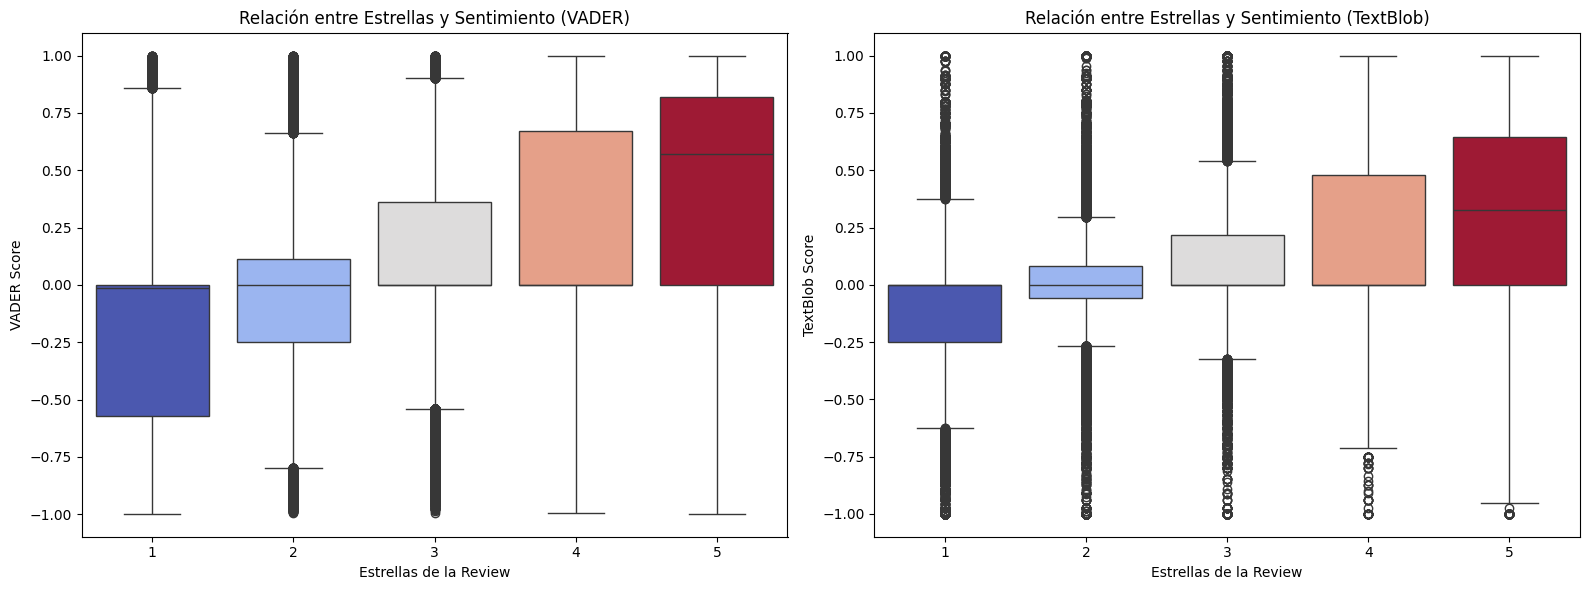

In [6]:
# Crear la figura con dos paneles
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico para VADER
sns.boxplot(x='rating', y='vader_score', hue='rating', data=reviews_final, palette="coolwarm", legend=False, ax=axes[0])
axes[0].set_title("Relación entre Estrellas y Sentimiento (VADER)")
axes[0].set_xlabel("Estrellas de la Review")
axes[0].set_ylabel("VADER Score")

# Gráfico para TextBlob
sns.boxplot(x='rating', y='textblob_score', hue='rating', data=reviews_final, palette="coolwarm", legend=False, ax=axes[1])
axes[1].set_title("Relación entre Estrellas y Sentimiento (TextBlob)")
axes[1].set_xlabel("Estrellas de la Review")
axes[1].set_ylabel("TextBlob Score")

# Ajustar el diseño
plt.tight_layout()
plt.show()

### Conclusiones sobre la Relación entre Estrellas y Sentimiento (VADER vs. TextBlob)

#### 1. Relación en VADER (Izquierda)
- Las reviews con **1 estrella** tienen puntajes de sentimiento predominantemente **negativos**, con una mediana cercana a **-0.5** y una amplia dispersión.
- A medida que aumentan las estrellas, el **sentimiento se vuelve más positivo**, con una clara tendencia ascendente en la mediana.
- Las reviews de **5 estrellas** tienen un sentimiento claramente positivo, con una mediana cercana a **0.75**.
- Existen algunos **outliers** (reseñas con muchas estrellas pero sentimiento negativo y viceversa).

#### 2. Relación en TextBlob (Derecha)
- El patrón es similar al de VADER: **mayor cantidad de estrellas → mayor sentimiento positivo**.
- Sin embargo, TextBlob parece ser **menos extremo** en las calificaciones negativas, con menor dispersión en los puntajes de sentimiento.
- La mediana del sentimiento para **1 estrella** está más cerca de **0** en comparación con VADER, lo que sugiere que TextBlob puede ser más neutral o conservador al clasificar texto negativo.

#### 3. Comparación entre VADER y TextBlob
- **Ambos modelos muestran una relación lógica**: a más estrellas, mayor sentimiento positivo.
- VADER tiende a **dar puntajes más extremos** en sentimientos negativos y positivos, mientras que TextBlob es **más moderado**.
- La diferencia más notable está en las reviews de **1 y 2 estrellas**, donde VADER asigna puntajes más bajos que TextBlob.

#### Conclusión General
Ambos modelos reflejan bien la relación entre calificaciones y sentimiento, pero **VADER es más agresivo en clasificaciones negativas**, mientras que **TextBlob es más conservador**. Dependiendo del análisis, uno u otro puede ser más útil.


---

## Análisis de correlaciones

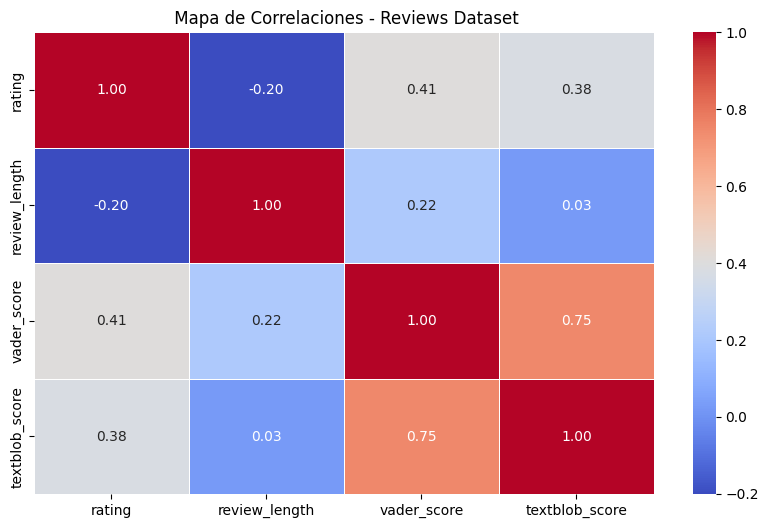

In [8]:
# Seleccionar solo las columnas numéricas para la correlación
corr_matrix = reviews_final[['rating', 'review_length', 'vader_score', 'textblob_score']].corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título del gráfico
plt.title(" Mapa de Correlaciones - Reviews Dataset")
plt.show()

### Conclusiones sobre el Mapa de Correlaciones - Reviews Dataset

#### 1. Correlación entre `rating` y `vader_score` / `textblob_score`
- La calificación (`rating`) tiene una correlación **moderada** con los puntajes de sentimiento:
  - **0.41 con VADER** → Indica que a mayor calificación, mayor sentimiento positivo según VADER.
  - **0.38 con TextBlob** → Similar a VADER, pero con una relación ligeramente más débil.
- Esto confirma que **las estrellas y el sentimiento del texto están alineados**, aunque no perfectamente, lo que sugiere que algunos reviews pueden ser neutros o contradictorios con su calificación.

#### 2. Correlación entre `review_length` y otros atributos
- La longitud de la review (`review_length`) tiene:
  - **Correlación negativa con `rating` (-0.20)** → Los reviews más largos tienden a ser de menor calificación, lo que sugiere que los usuarios insatisfechos escriben reseñas más detalladas.
  - **Correlación baja con `vader_score` (0.22)** → Las reviews más largas tienden a tener un ligero sesgo hacia un sentimiento más positivo en VADER.
  - **Correlación casi nula con `textblob_score` (0.03)** → TextBlob no parece influenciado por la cantidad de palabras en una reseña.

#### 3. Relación entre `vader_score` y `textblob_score`
- Hay una **fuerte correlación positiva (0.75) entre VADER y TextBlob**, lo que indica que ambos modelos de análisis de sentimiento generan resultados similares en la mayoría de los casos.

#### Conclusión General
- Las calificaciones y los puntajes de sentimiento tienen una **correlación moderada**, lo que confirma que el análisis de sentimiento refleja en gran medida la calificación asignada por los usuarios.
- Las reviews más largas tienden a estar asociadas con **calificaciones más bajas**, lo que sugiere que los clientes insatisfechos escriben reseñas más detalladas.
- VADER y TextBlob son **altamente compatibles**, pero tienen ligeras diferencias en la interpretación del sentimiento en textos largos.

>Este análisis permite comprender mejor la relación entre la longitud de las reseñas, el sentimiento textual y la calificación otorgada por los usuarios.


In [9]:
reviews_final.to_parquet('reviews_con_sentimiento_gm.parquet')